In [3]:
import numpy as np
import cv2
import math
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## histogram equalization

In [22]:
def show_image_and_hist(image,title1="transformed image",title2="histogram distribution"):
    """
    展示图片与其对应的直方图
    """ 
    ax = []
    fig=plt.figure(figsize=(9, 4))
    ax.append(fig.add_subplot(1, 2, 1))
    ax[-1].set_title(title1)
    plt.imshow(image,cmap='gray')
    
    ax.append(fig.add_subplot(1, 2, 2))
    ax[-1].set_title(title2)
    flatten = image.ravel()
    plt.hist(flatten,np.arange(0,256))
    
    plt.show()

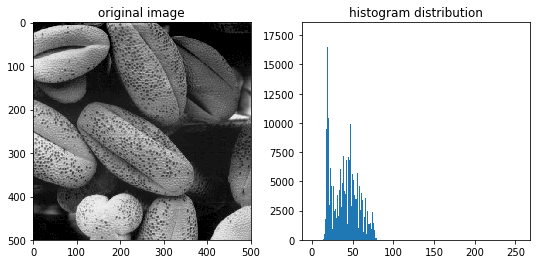

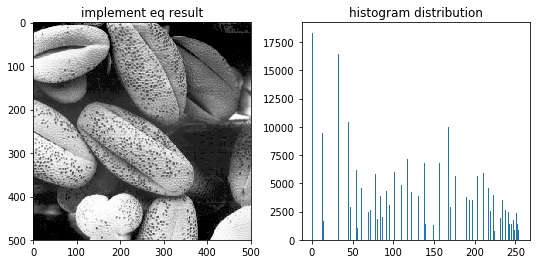

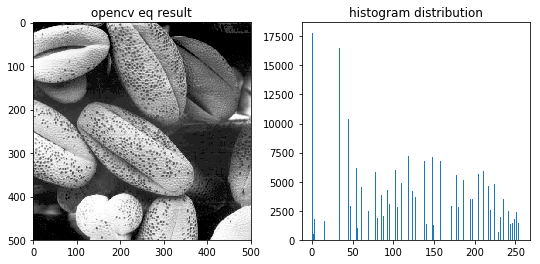

In [48]:
""" 读入图片(灰度图)"""
path = 'images/Fig0320(4)(bottom_left).tif'
image = cv2.imread(path, 0)
g = cv2.equalizeHist(image)


hist, bins = np.histogram(image.flatten(),256,[0,255])

#cumulative distribution function
cdf = hist.cumsum() 

cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = ((cdf_m - cdf_m.min())*255)/(cdf_m.max() - cdf_m.min())
cdf_scaled = np.ma.filled(cdf_m,0).astype('uint8')

#image2 = np.zeros_like(image)
image2 = cdf_scaled[image].astype('uint8')

#for x in range(image.shape[0]):
#    for y in range(image.shape[1]):
#        image2[x,y] = cdf_scaled[image[x,y]]


show_image_and_hist(image,title1='original image')
show_image_and_hist(image2,title1='implement eq result')
show_image_and_hist(g,title1='opencv eq result')

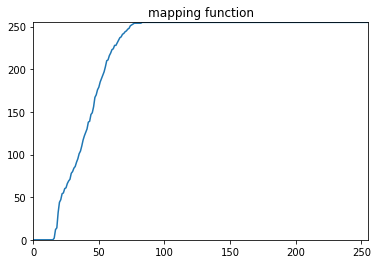

In [50]:
x_values = np.arange(0,256)
y_values = cdf_scaled[x_values].astype('uint8')

plt.title('mapping function')
plt.xlim((0,255))
plt.ylim((0,255))
plt.plot(x_values, y_values)

In [18]:
def generate_two_modes_gaussian(m1,sigma1,m2,sigma2,A1,A2,k):
    c1=A1*(1/((2*math.pi)**0.5)*sigma1)
    k1 = 2*(sigma1**2)
    c2=A2*(1/((2*math.pi)**0.5)*sigma2)
    k2 = 2*(sigma2**2)
    z = np.arange(0.0,1.0,1/256)
    #print(z)
    p = k + c1*np.exp(-((z-m1)**2)/k1)+c2*np.exp(-((z-m2)**2)/k2)
    p = p/np.sum(p)
    return p

In [27]:
def find_nearest_above(my_array, target):
    # my_array是指定参考图像直方图均衡化之后的数组
    # target是原图灰度值在直方图均衡化图中对应的灰度值
    diff = my_array - target
    # 布尔数组
    mask = np.ma.less_equal(diff, -1)
    
    if np.all(mask):# 如果target比my_array都大
        c = np.abs(diff).argmin()
        return c # returns min index of the nearest if target is greater than any value
    masked_diff = np.ma.masked_array(diff, mask)
    return masked_diff.argmin()

In [29]:
def hist_match(original, specified_pdf):
 
    oldshape = original.shape
    original = original.ravel()
   
    
    # s_values 返回结果是升序排列的
    s_values, bin_idx, s_counts = np.unique(original, return_inverse=True,return_counts=True)
    
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    
    t_quantiles = np.cumsum(specified_pdf).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
 
    # np.around 0:[0,0.5], 1:(0.5,1]
    sour = np.around(s_quantiles*255)
    temp = np.around(t_quantiles*255)
    #print(sour[:15])
    
    b=[]
    for data in sour[:]:
        b.append(find_nearest_above(temp,data))
    #b就是映射后的灰度级
    b= np.array(b,dtype='uint8')
    # b[bin_idx]相当于逆变换
    return s_values, b, b[bin_idx].reshape(oldshape)

## histogram matching

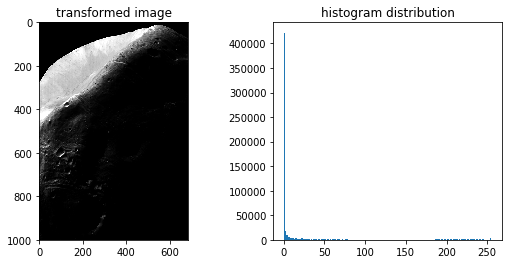

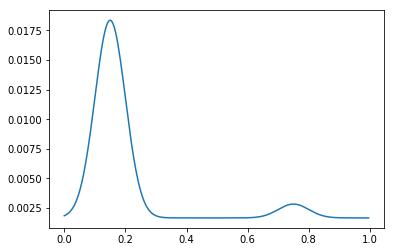

In [30]:
""" 读入图片(灰度图)"""
path = 'images/Fig0323(a)(mars_moon_phobos).tif'
image = cv2.imread(path, 0)
show_image_and_hist(image)

"""规定的直方图"""
gaussians = generate_two_modes_gaussian(m1=0.15,sigma1=0.05,m2=0.75, sigma2=0.05,A1=1,A2=0.07,k=0.002)
x = np.arange(0,1,1/256)
plt.plot(x,gaussians)

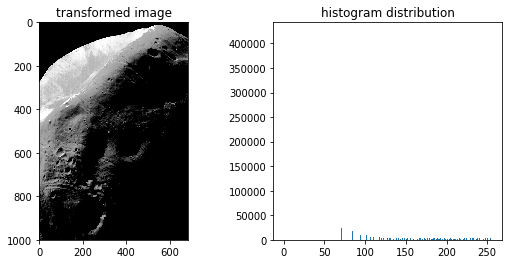

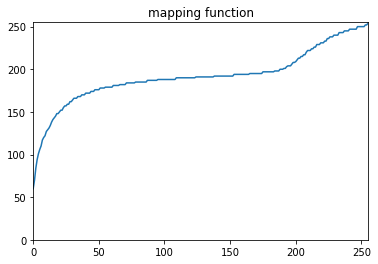

In [31]:
s_values,mapping, matched_image = hist_match(image, gaussians)
#print(len(mapping))
show_image_and_hist(matched_image)
plt.title('mapping function')
plt.xlim((0,255))
plt.ylim((0,255))
plt.plot(s_values, mapping)

## intensity transformation

**用来展示的工具函数**

In [38]:
def show_image_and_transformed(image, transformed):
    """
    展示原图与灰度变换后的图像
    """ 
    ax = []
    fig=plt.figure(figsize=(9, 4))
    ax.append(fig.add_subplot(1, 2, 1))
    ax[-1].set_title("origin image")
    plt.imshow(image,cmap='gray')
    
    ax.append(fig.add_subplot(1, 2, 2))
    ax[-1].set_title("transformed image")
    plt.imshow(transformed,cmap='gray')
    
    plt.show()

In [4]:
breast_img = 'images/Fig0304(a)(breast_digital_Xray).tif'
img = cv2.imread(breast_img, 0)

In [5]:
if img.dtype=='uint8':
    img = img.astype('float')/255.

### Image Negative

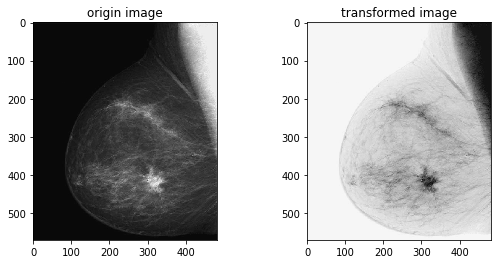

In [7]:
negative = 1. - img 
show_image_and_transformed(img, negative)

### Image Stretch

In [17]:
# ref: https://stackoverflow.com/questions/39767612/what-is-the-equivalent-of-matlabs-imadjust-in-python
# TODO 与imadjust2统一成相同的数据范围
def imadjust(src,a=None,b=None,c=None,d=None,gamma=1):
    # Similar to imadjust in MATLAB.
    # Converts an image range from [a,b] to [c,d].
    # The Equation of a line can be used for this transformation:
    #   y=((d-c)/(b-a))*(x-a)+c
    # However, it is better to use a more generalized equation:
    #   y=((x-a)/(b-a))^gamma*(d-c)+c
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.
    assert len(src.shape) == 2 ,'Input image should be 2-dims'
    if np.max(src)>1.0:
        src = src.astype('float')/255.
        
    if not a:
        a = max(np.min(src), 0.)
    if not b:
        b = min(np.max(src), 1.)
    if not c:
        c = 0.
    if not d:
        d = 1.
    # c,d=1,0可以模拟负片效果
    if d>c:
        dst = (((src - a) / (b - a)) ** gamma) * (d - c) + c
    else:
        dst = 1 - (((src - a) / (b - a)) ** gamma) * (c - d) + c
    return dst

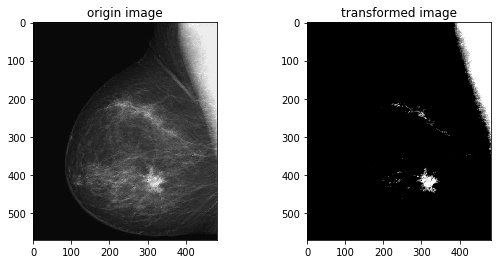

In [12]:
strecth1 = imadjust(img,0.5,0.75,0,1)
strecth1[strecth1<0]=0
strecth1[strecth1>1]=1
show_image_and_transformed(img, strecth1)

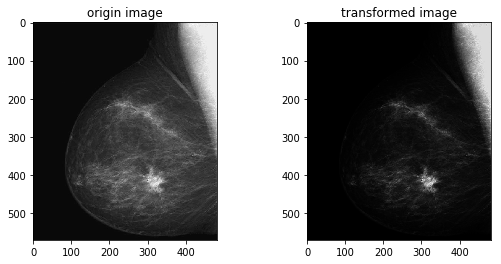

In [19]:
strecth2 = imadjust(img,None,None,None,None,2)
strecth2[strecth2<0]=0
strecth2[strecth2>1]=1
show_image_and_transformed(img, strecth2)

**较为复杂的imadjust实现，可以实现阈值的自动计算，相当于matlab中的imadjust(f,stretchlim(f),[])**

In [51]:
# ref:https://stackoverflow.com/questions/39767612/what-is-the-equivalent-of-matlabs-imadjust-in-python
import bisect
def imadjust2(src, tol=1, vin=[0,255], vout=(0,255)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    assert len(src.shape) == 2 ,'Input image should be 2-dims'
    if np.max(src)<=1.0:
        src = (src*255).astype('uint8')
    

    tol = max(0, min(100, tol))

    if tol > 0:#当该参数不为0时，自动计算图像灰度级的顶部和底部tol%的像素值作为vin
        # Compute in and out limits
        # Histogram
        hist = np.histogram(src,bins=list(range(257)),range=(0,255))[0]

        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, 256): cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)
        print(vin)

    # Stretching
    
    vs = src-vin[0]
    vs[src<vin[0]]=0
    if vout[1]>vout[0]:
        scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
        vd = vs*scale+0.5 + vout[0]
        vd[vd>vout[1]] = vout[1]
        dst = vd
    else:
        scale = (vout[0] - vout[1]) / (vin[1] - vin[0])
        vd = vs*scale+0.5 + vout[1]
        vd[vd>vout[0]] = vout[0]
        dst = 255 - vd
    return dst

[30, 238]


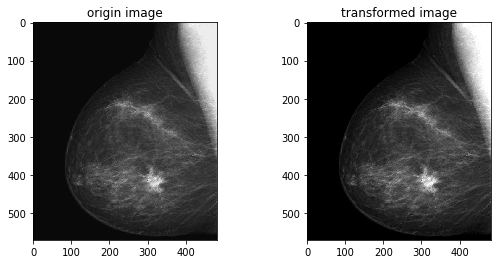

In [53]:
strecth3 = imadjust2(img)
show_image_and_transformed(img, strecth3)

[30, 238]


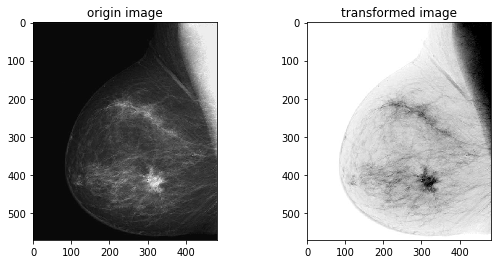

In [52]:
strecth4 = imadjust2(img,1,[0,255],(255,0))# 负片效果
show_image_and_transformed(img, strecth4)

### Log Transformation

In [85]:
img = cv2.imread(breast_img,0)
# 由于傅立叶变换在第四章才接触，因此此处还是使用已有api实现傅立叶变换
# 在第四章将自己实现傅立叶变换
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
fshift = fshift + 1e-7# 避免负数过小
print(np.max(fshift))
print(np.min(fshift))

(18362332.0000001+0j)
(-1342761.064578803-564281.0581990161j)


In [86]:
def normalize(img, target_min=0, target_max=1):
    imin,imax = np.min(img), np.max(img)
    scale = (target_max - target_min) / (imax - imin)
    dst = img*scale + target_min
    dst[dst>target_max] = target_max
    return dst

(16.725812004800726+0j)
(1+0j)


/Users/cwy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


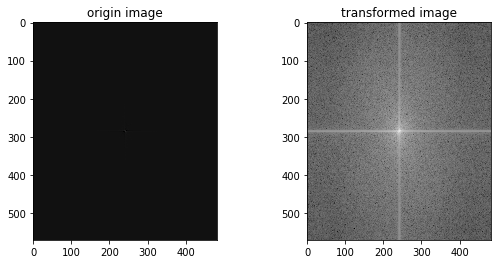

In [87]:
c = 1 # c一般取1.0
g = c*(np.log(1 + fshift))
print(np.max(g))
g = normalize(g, 0, 1)
print(np.max(g))
# 频谱是复数
show_image_and_transformed(normalize(fshift).astype('float'), g.astype('float'))

**Gamma( Power Law) Transformation**

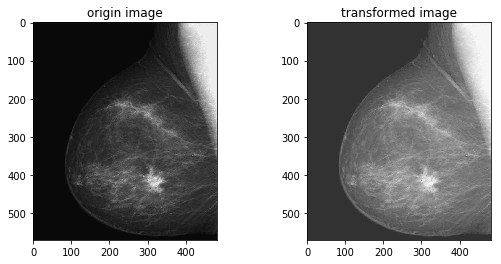

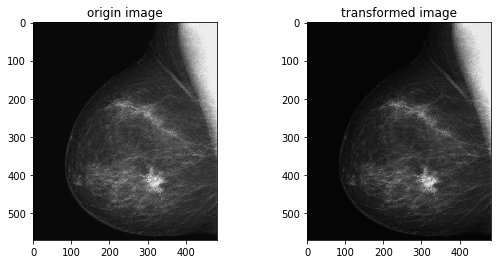

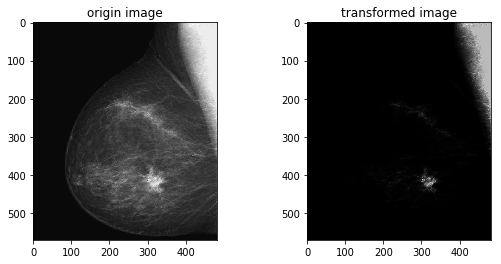

In [89]:
breast_img = 'images/Fig0304(a)(breast_digital_Xray).tif'
img = cv2.imread(breast_img, 0)
if img.dtype=='uint8':
    img = img.astype('float')/255.
for gamma in [0.5, 1.2, 4.2]: 
    gamma_corrected = imadjust(img,None,None,None,None,gamma)
    show_image_and_transformed(img, gamma_corrected)

### Piecewise-Linear Transformation

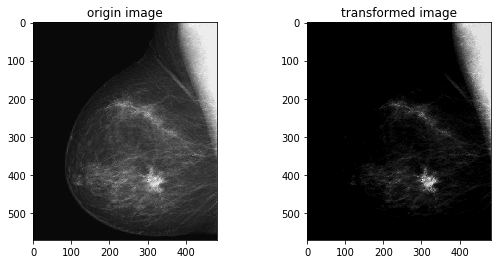

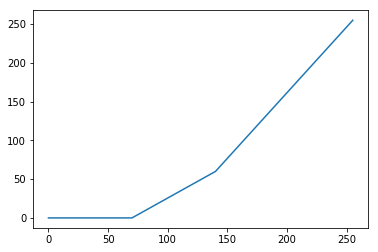

In [90]:
breast_img = 'images/Fig0304(a)(breast_digital_Xray).tif'
img = cv2.imread(breast_img, 0)
def pixelVal(pix, r1, s1, r2, s2): 
    if (0 <= pix and pix <= r1): 
        return (s1 / r1)*pix 
    elif (r1 < pix and pix <= r2): 
        return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1 
    else: 
        return ((255 - s2)/(255 - r2)) * (pix - r2) + s2 

r1 = 70
s1 = 0
r2 = 140
s2 = 60
  
# 类似于pandas的apply，可以将函数应用在数组的每一个元素上
pixelVal_vec = np.vectorize(pixelVal) 
  
# Apply contrast stretching. 
contrast_stretched = pixelVal_vec(img, r1, s1, r2, s2) 
contrast_stretched =  np.array(contrast_stretched, dtype='uint8')
#print(np.unique(img))
#print(np.unique(contrast_stretched))
# 注意用plt的话，对于0-255范围的数需要转化为整形，否则浮点数默认范围是0-1
show_image_and_transformed(img, np.array(contrast_stretched, dtype='uint8'))

x_index = np.arange(0,256)
plt.plot(x_index,pixelVal_vec(x_index,r1, s1, r2, s2))

## spatial filtering

会在第四次作业实现，此处略